# Practical 3: Wet snow detection using Sentinel 1 SAR data

Content prepared by Swun Wunna Htet

Step 1: install GEE python API in the colab environment

In [ ]:
# ! pip install geemap

!pip install pycrs
!pip install geetools
!pip install cartopy

# geemap.update_package()

Step 2: import python libraries to utilize

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import ee
import geemap
import geetools
import cartopy.crs as ccrs
from geemap import cartoee

Step 3: Authenticate and initialize earthe engine. If you have a specific GEE projects specify that project

In [ ]:
ee.Authenticate()
ee.Initialize(project = 'ee-swunait')

Connecting with your google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# date filter of image collection
start = ee.Date('2020-01-01')
end = ee.Date('2020-12-31')

We will upload our shapefile of area of interest into your GEE project assets.

In case you have error message (No module names pycrs), run this code in an new cell;
! pip install pycrs

In [ ]:
aoi = geemap.shp_to_ee(r'/content/drive/MyDrive/cryosphere_monitoring/watershed_subset.shp')

In [ ]:
# Let's see our metadata of aoi. AOI is now termed as Feature Collection.
display(aoi)

We will filter our Sentinel1 image collection with date and only within area of interest.

In [ ]:
# importing the S1 imagecollection specific within the date range
# for this exercise, we will test out with HW co-polarization band
band = 'VV'

s1 = ee.ImageCollection("COPERNICUS/S1_GRD")
s1 = s1.filterBounds(aoi).filterDate(start,end).select(band).filterMetadata('orbitProperties_pass', 'equals', 'DESCENDING')

In [ ]:
display(s1)

We need to make a mosaic map first for each day of year

In [ ]:
def mergebyDate(imcol):

  # from image collection to a list
  imglist = imcol.toList(imcol.size())

  # driver function
  def uniquedate(img):
    return ee.Image(img).date().format('YYYY-MM-dd');

  # applying driver function
  uniquedates = imglist.map(uniquedate).distinct()

  # driver function for mapping the mosaics based on unique dates
  def mosaicDriver(dateid):
    id = ee.Date(dateid)

    image = (imcol.filterDate(id, id.advance(1, 'day'))).mosaic().clip(aoi)
    return image.set(
        {'system:time_start': id.millis(),
        'system:id': id.format('YYYY-MM-dd')});

  mosaicImglist = uniquedates.map(mosaicDriver)

  return ee.ImageCollection(mosaicImglist)

In [ ]:
s1_mosaic = mergebyDate(s1)

In [ ]:
display(s1_mosaic)
display(s1_mosaic.size())

Time Series extraction of the backscatter values of SAR images

In [ ]:
def extractbackscattertime(img):
  ndsi = img.select(band)

  mean = ndsi.reduceRegion(reducer = ee.Reducer.mean(),
                           geometry = aoi,
                           bestEffort = True)
  val = mean.get(band)

  return img.set('DateDict', img.date().format()).set('VH', val)

In [ ]:
radar_timeseries = s1_mosaic.map(extractbackscattertime)

In [ ]:
display(radar_timeseries)

Using two lists into pandas dataframe, and plotting

In [ ]:
nested_list = radar_timeseries.reduceColumns(ee.Reducer.toList(2), ['DateDict', 'VH']).values().get(0)

df =pd.DataFrame(nested_list.getInfo(), columns=['DateDict', 'Vh'])
df['DateDict'] = pd.to_datetime(df['DateDict'])
df = df.set_index('DateDict')

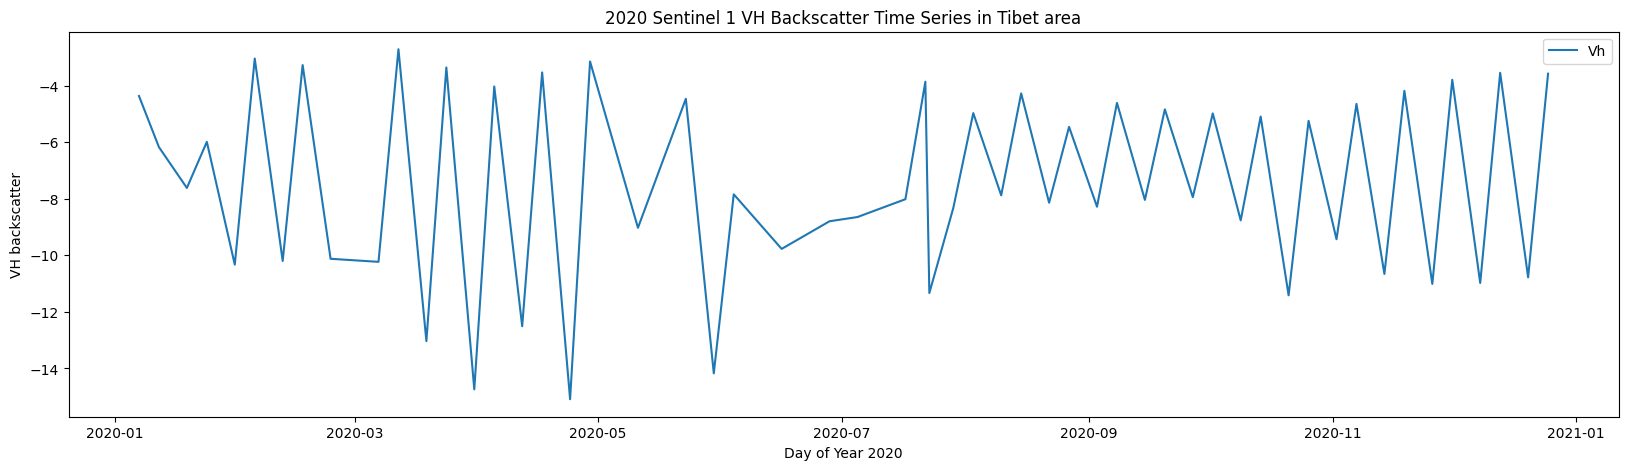

In [ ]:
fig, ax = plt.subplots(figsize = (20, 5))

sns.lineplot(data = df, ax = ax)

ax.set_ylabel('VH backscatter', fontsize = 10)
ax.set_xlabel('Day of Year 2020', fontsize = 10)
ax.set_title('2020 Sentinel 1 VH Backscatter Time Series in Tibet area', fontsize = 12)

plt.show()

Saving radar backscatter as excel sheets

In [ ]:
writer = pd.ExcelWriter('/content/drive/MyDrive/cryosphere_monitoring/S1_radar_timeseries_2020.xlsx', engine = 'openpyxl')

df.to_excel(writer, sheet_name = 'VH')
writer.close()

By Nagler's method requirement, we need to select the reference SAR with dry snow condition during winter time. So we will select DEC 25th as reference map. The threshold is -3 dB. Any snow pixels with < -3 dB will be considered as snow.

In [ ]:
def wetmapdetect(img):

  ratio = img.divide(reference)

  wet_area = ratio.lt(ee.Image.constant(-3)).rename('wet_snow')


  return wet_area.copyProperties(img, ['system:time_start'])

In [ ]:
wet_snow_col = s1_mosaic.map(wetmapdetect)

We will visualize the wet snow maps of the first DOY and reference' DOY

In [ ]:
ref_WET = wet_snow_col.filterDate(ee.Date('2020-12-24'), ee.Date('2020-12-30')).first()
display(ref_WET)

reference = s1_mosaic.filterDate(ee.Date('2020-12-24'), ee.Date('2020-12-30')).first()
display(reference)

In [ ]:
basemap = geemap.Map()

In [ ]:
# providing the visualization parameters, white means dry snow, blue means wet snow.
vis_params = {"min": -22, "max": -12, 'palette':['black', 'white']}
basemap.addLayer(reference, vis_params, 'reference')
basemap.addLayer(s1_mosaic.first(), vis_params, 'first')
basemap.addLayer(wet_snow_col.first(), {'palette': ['white', 'blue']}, 'first_wet')
basemap.addLayer(ref_WET, {'palette': ['white', 'blue']}, 'REF_wet')

In [ ]:
basemap

Map(bottom=27230.0, center=[30.51494904517773, 93.16689664788119], controls=(WidgetControl(options=['position'…

Creating timelapse of Wet snow for 365 days (Animation of Wetness)

In [ ]:
# Define arguments for animation function parameters.
video_args = {
    'dimensions': 400,
    'region': aoi.geometry(),
    'framesPerSecond': 10,
    'bands': ['wet_snow'],
    'min': 0,
    'max': 1,
    'palette':['white', 'blue']
}

In [ ]:
geemap.download_ee_video(wet_snow_col, video_args, r'/content/drive/MyDrive/cryosphere_monitoring/S1_wet_snow_timelapse.gif')

Generating URL...
Please wait ...
The GIF image has been saved to: /content/drive/MyDrive/cryosphere_monitoring/S1_wet_snow_timelapse.gif


Exporting Daily Wet Snow Images

In [ ]:
tasks = geetools.batch.Export.imagecollection.toDrive(
    collection = wet_snow_col,
    folder = 'cryosphere_monitoring',
    region = aoi.geometry(),
    namePattern = 'Wet_Snow_Classes_{id}',
    scale = 500,
    datePattern = 'YYYYMMdd'
)

---

End of Practical 3: Snow Wetness Detection using SAR Images

---